In [1]:
import sys
path2cpp_pkg = "/Users/mariusmahiout/Documents/repos/ising_core/build"
sys.path.append(path2cpp_pkg)
import ising

import os
os.chdir("/Users/mariusmahiout/Documents/repos/ising_core/python/src")
import preprocessing as pre
import model_eval as eval
import utils as utils
import misc_plotting as misc_plotting
import isingfitter as fitter
os.chdir("../..")
os.getcwd()

import numpy as np
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from IPython.display import display, HTML
from ipywidgets import HBox, VBox, widgets

plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))

In [2]:
utils.is_notebook()

True

In [66]:
mouse_name = "Angie"
sens_param = "time"
sample_names = ["performing1", "performing2", "observing1", "observing2"]
path = "analyses"
utils.make_dir(path)

bin_widths = [50, 150, 250]
labels = [str(bin_width) + " ms" for bin_width in bin_widths]

num_units = 100
# M2, mouse Angie
# perfomring
samples1 = [pre.get_recording_sample(fname="RESULTS_Angie_20170825_1220_allbeh_1000s.mat", mouse_name=mouse_name, bin_width=bin_width, num_units=num_units) for bin_width in bin_widths]
samples2 = [pre.get_recording_sample(fname="RESULTS_Angie_20170825_1232_allbeh_1000s.mat", mouse_name=mouse_name, bin_width=bin_width, num_units=num_units) for bin_width in bin_widths]

# observing
samples3 = [pre.get_recording_sample(fname="RESULTS_Angie_20170825_1248_allbeh_1000s.mat", mouse_name=mouse_name, bin_width=bin_width, num_units=num_units) for bin_width in bin_widths]
samples4 = [pre.get_recording_sample(fname="RESULTS_Angie_20170825_1158_allbeh_1000s.mat", mouse_name=mouse_name, bin_width=bin_width, num_units=num_units) for bin_width in bin_widths]

Directory 'analyses' already exists.


In [67]:
sample = samples1[0]

In [68]:
num_sims = 30_000
num_burn = 5_000
lr = 0.1
win_size = 10
tol_ml = 1e-3
tol_pl = 1e-9
max_steps = 5000

In [69]:
###############
# EQUILIBRIUM #
###############

# setting up model
h_init = np.random.uniform(-1.5, 1.5, num_units)
J_init = np.random.normal(0,  1,  (num_units, num_units))
J_init = (J_init.T + J_init) * np.sqrt(2) / 2
np.fill_diagonal(J_init, 0)

eq_model = ising.EqModel(J_init, h_init)

eq_fitter = fitter.EqFitter(eq_model)
eq_fitter.TAP(sample)

# inference
use_llh = False

eq_fitter.maximize_likelihood(
        sample=sample, 
        max_steps=3000, 
        learning_rate=0.05,
        win_size = win_size,
        tolerance= tol_ml, 
        num_sims=50_000, 
        num_burn=5_000,
        calc_llh=False
)

# eq_fitter.maximize_likelihood(
#         sample=sample, 
#         max_steps=6000, 
#         learning_rate=0.025,
#         win_size = win_size,
#         tolerance= tol_ml, 
#         num_sims=50_000, 
#         num_burn=5_000,
#         calc_llh=False
# )

# eq_fitter.maximize_likelihood(
#         sample=sample, 
#         max_steps=8000, 
#         learning_rate=0.01,
#         win_size = win_size,
#         tolerance= tol_ml, 
#         num_sims=50_000, 
#         num_burn=5_000,
#         calc_llh=False
# )

In [70]:
###################
# NON-EQUILIBRIUM #
###################

# setting up model
h_init = np.random.uniform(-1.5, 1.5, num_units)
J_init = np.random.normal(0,  1,  (num_units, num_units))
J_init = (J_init.T + J_init) * np.sqrt(2) / 2
np.fill_diagonal(J_init, 0)

neq_model = ising.NeqModel(J_init, h_init)

neq_fitter = fitter.NeqFitter(neq_model)
neq_fitter.TAP(sample)

# inference
use_llh = False

neq_fitter.maximize_likelihood(
    sample=sample, 
    max_steps=3000, 
    learning_rate=0.05,
    win_size = win_size,
    tolerance= 1e-16, 
)

# neq_fitter.maximize_likelihood(
#     sample=sample, 
#     max_steps=6000, 
#     learning_rate=0.025,
#     win_size = win_size,
#     tolerance= 1e-16, 
# )

# neq_fitter.maximize_likelihood(
#     sample=sample, 
#     max_steps=8000, 
#     learning_rate=0.01,
#     win_size = win_size,
#     tolerance= 1e-16, 
# )

In [71]:
misc_plotting.convergence_plot(eq_fitter, plot_llh=False, path="./analyses/eq_convergence/eq_neuro1.pdf")

Button(description='Save Figure', style=ButtonStyle())

In [72]:
misc_plotting.convergence_plot(neq_fitter, plot_llh=False, path="./analyses/eq_convergence/neq_neuro1.pdf")

Button(description='Save Figure', style=ButtonStyle())

In [73]:
eq_sim = eq_model.simulate(num_sims, num_burn)
neq_sim = neq_model.simulate(num_sims, num_burn)

In [74]:
def get_coactivation_distribution(states: np.ndarray):
    num_units, num_bins = states.shape
    rel_freq = np.zeros(num_units + 1)
    for bin in range(num_bins):
        active_units = states[:, bin] == 1
        num_active = int(np.count_nonzero(active_units))
        rel_freq[num_active] += 1 / num_bins
    return rel_freq

#eq_sim.getStates().shape
eq_coac_distr = get_coactivation_distribution(eq_sim.getStates())
neq_coac_distr = get_coactivation_distribution(neq_sim.getStates())
gt_coac_distr = get_coactivation_distribution(sample.getStates())

In [86]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import seaborn as sns
sns.set_theme()
sns.set_style(rc = {'axes.facecolor': '#e5ecf6'})

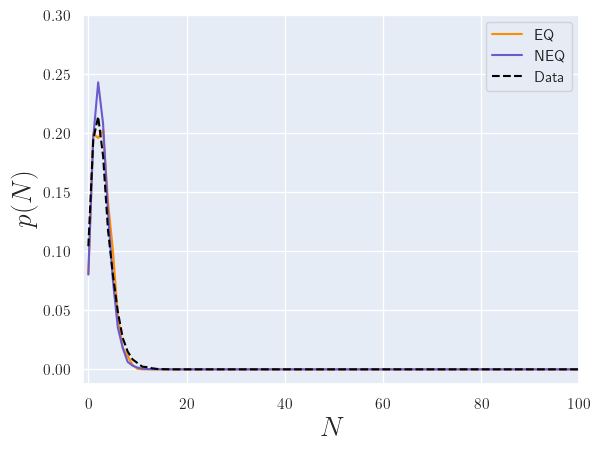

In [102]:
plt.plot(eq_coac_distr, color="darkorange", label="EQ")
plt.plot(neq_coac_distr, color="slateblue", label="NEQ")
plt.plot(gt_coac_distr, color="black", linestyle="--", label="Data")

plt.xlim([-1,100])
plt.ylim([-0.0125,0.3])
plt.legend()
plt.xlabel(r"$N$", fontsize=20)
plt.ylabel(r"$p(N)$", fontsize=20)
plt.show()

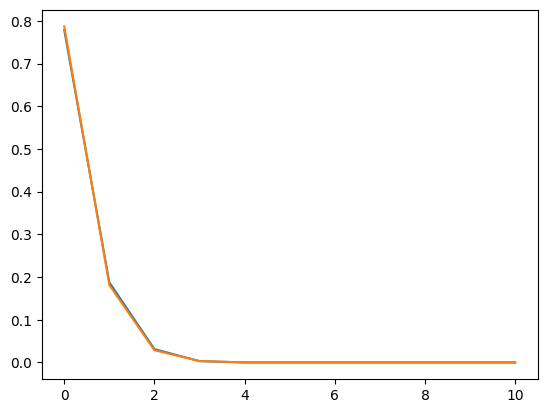

In [44]:
xmin = 0.24
xmax = 1.8
color = "darkorange"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,7))

color = ["darkorange", "darkcyan", "blueviolet", "limegreen"]
colors = dict(
    (Ls[i], color[i]) for i in range(len(Ls))
)
for L in Ls[::-1]:
    ax[0].fill_between(x=temp_range / 2.3, y1=av_mag[L] +sd_mag[L], y2 = av_mag[L] - sd_mag[L], alpha=.25, color=colors[L])
    ax[0].plot(temp_range / 2.3, av_mag[L], color=colors[L])
    ax[0].set_ylabel(r'$\langle |M| \rangle$', fontsize=18)
    ax[0].vlines(x=[1], ymin=-.5, ymax=1.2, color="black", linestyle="--", alpha=.5)
    
    ax[0].set_xlim([xmin,xmax])
    ax[0].set_ylim([0.1,1.1])
    ax[0].set_xlabel('$T/T_c$', fontsize=20)


    ax[1].fill_between(x=temp_range / 2.3, y1=av_chi[L] + sd_chi[L], y2 = av_chi[L] - sd_chi[L], alpha=.25, color=colors[L])
    ax[1].plot(temp_range / 2.3, av_chi[L], color=colors[L], label=rf"$L = {L}$")
    ax[1].set_ylabel(r'$\chi / N$', fontsize=18)
    ax[1].vlines(x=[1], ymin=-.5, ymax=30, color="black", linestyle="--", alpha=.5)

    ax[1].set_ylim([-.5,20])
    ax[1].set_xlim([xmin,xmax])
    ax[1].set_xlabel('$T/T_c$', fontsize=20)

   

fig.legend()
fig.tight_layout()
#fig.suptitle('$T/T_c$', fontsize=20, y = 0.001)

plt.savefig("phase_transition.pdf")

plt.show()


In [76]:
labels = ["EQ", "NEQ"]
metadata = utils.get_metadata( # gotta change this
    num_units=num_units,
    is_empirical_analysis=False,
    eq_inv_methods=labels,
    num_sims=num_sims,
    true_fields="Angie performing 1",
    true_couplings="Angie performing 1",
    num_steps=max_steps,
    learning_rate=lr,
    is_converged=None,
    num_sims_ml=num_sims,
    num_burn_ml=num_burn,
)


analysis_name = "rec_test"
bin_width = 0
analysis_path = utils.get_analysis_path(analysis_name, num_units, bin_width)

layout_spec = {
    ("means", "scatter"): (1, 1),
    ("ccorrs", "scatter"): (1, 2),
    ("dcorrs", "scatter"): (2, 1),    
    ("tricorrs", "scatter"): (2, 2),    
}

ising_eval = eval.IsingEval(
    analysis_path=analysis_path,
    metadata=metadata,
    true_model=None,
    est_models=[eq_model, neq_model],
    true_sample=sample,
    est_samples=[eq_sim, neq_sim],
    labels=labels,
    layout_spec=layout_spec,
)
ising_eval.generate_plots(True)

    'data': [{'legendgroup': 'EQ',
              'marker': {'color': 'darkorange…

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

def plot_coupling_graph_and_matrix(J: np.ndarray, threshold: float=0.2, num_units: int=None, directed: bool=True, fname: str=None):
    if directed:
        G = nx.DiGraph()
        arrow_size = 15
    else:
        G = nx.Graph()
        arrow_size = None

    if num_units is None:
        num_units = J.shape[0]

    for i in range(num_units):
        G.add_node(i)

    for i in range(num_units):
        for j in range(num_units):
            if i != j and abs(J[i, j]) > threshold:
                G.add_edge(i, j, weight=J[i, j])

    layout = nx.circular_layout(G)

    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    max_weight = np.max(np.abs(weights)) + 0.01
    min_weight = - max_weight

    # Normalize weights for thickness
    normalized_weights = [4 * abs(w) / max(abs(max_weight), abs(min_weight)) for w in weights]

    cmap = plt.cm.bwr
    norm = Normalize(vmin=min_weight, vmax=max_weight)
    edge_colors = [cmap(norm(w)) for w in weights]

    # Create the plot layout
    #fig = plt.figure(figsize=(12, 12))
    #gs = gridspec.GridSpec(1, 1, width_ratios=[1.4, 1])  # Adjusted width ratios

    # Plot the graph
    #ax1 = fig.add_subplot(gs[0])

    fig, ax1 = plt.subplots(figsize=(7.5,7.5))
    nx.draw_networkx_nodes(G, layout, node_color='slategrey', node_size=300, ax=ax1)
    nx.draw_networkx_labels(G, layout, font_size=14, font_color='white', ax=ax1)
    if directed:
        nx.draw_networkx_edges(G, layout, edge_color=edge_colors, width=normalized_weights, ax=ax1, arrows=directed, arrowstyle='->', arrowsize=arrow_size)
    else:
        nx.draw_networkx_edges(G, layout, edge_color=edge_colors, width=normalized_weights, ax=ax1)
    ax1.axis('off')

    # # Plot the coupling matrix as a heatmap
    # ax2 = fig.add_subplot(gs[1])
    # cax = ax2.matshow(J[:num_units, :num_units], cmap=cmap, norm=norm)
    # ax2.set_xlabel(r'Unit $i$', fontsize=17)
    # ax2.set_ylabel(r'Unit $j$', fontsize=17)

    # # Create color bar
    # sm = ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])
    # cbar = fig.colorbar(sm, ax=[ax1, ax2], fraction=0.03, pad=0.04)
    # cbar.set_label(r'$J_{ij}$', fontsize=22)

    if fname is not None:
        plt.savefig( f"analyses/{fname}.pdf")
    plt.show()

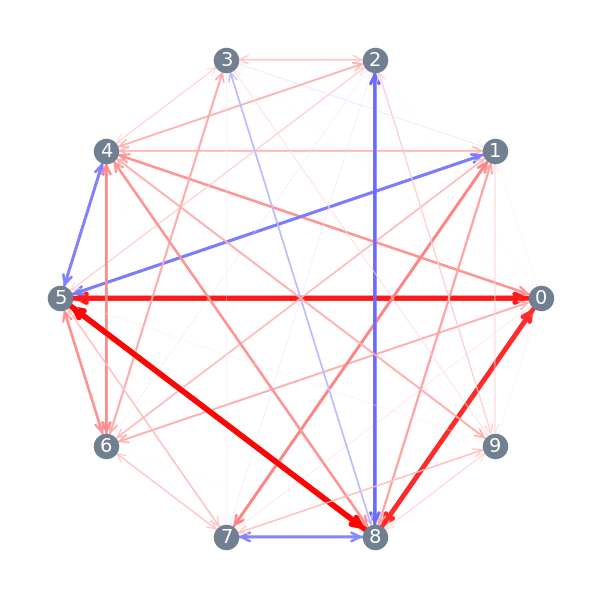

In [35]:

plot_coupling_graph_and_matrix(J=eq_model.getCouplings(), threshold=.0, num_units=10, directed=True, fname="illustration")


In [17]:
plot_coupling_graph_and_matrix(J=eq_model.getCouplings(), threshold=0.6, num_units=10, directed=False, fname="coupling_graph_eq200")

ValueError: zero-size array to reduction operation maximum which has no identity

In [18]:
neq_model.getCouplings()

array([[ 0.        ,  0.08108315,  0.11026293, -0.25367483,  0.34611976,
         0.40059744,  0.19055041,  0.10025308,  0.57310037, -0.18970245],
       [ 0.0654687 ,  0.        , -0.0494038 , -0.05251123,  0.26246717,
        -0.0996003 ,  0.25399667,  0.27670559,  0.26129867,  0.10429253],
       [-0.25696304,  0.03473087,  0.        , -0.00486978,  0.21216837,
         0.10064456,  0.04131631, -0.07102884, -0.81657377,  0.1133371 ],
       [-0.07317743,  0.06400054,  0.09140082,  0.        , -0.07270586,
         0.05861121,  0.05731729, -0.13953714, -0.0209282 ,  0.06467901],
       [ 0.23317807,  0.29533824,  0.25883292,  0.03911052,  0.        ,
        -1.24883048, -0.2095876 , -0.01203446,  0.1617781 , -0.1896693 ],
       [ 0.40883428, -0.14948036, -0.16578337,  0.05778167, -1.05003532,
         0.        ,  0.21970909,  0.10559506,  0.4242537 ,  0.00146615],
       [-0.09354649,  0.24553386, -0.09240365,  0.12767423,  0.07894418,
         0.28917786,  0.        ,  0.12259534